## Theorem


### Gated Memory Cell
LSTM introduces a `memory cell` that **has the same shape as hidden state**, we need three gates to control this cell:
1. Output gate: the gate to read out the entries
2. Input gate: the gate to decide when to read data into cell
3. Forget gate: the gate to reset content of the cell

## Working Flow
Same as RNN and GRU, input is $X_t$ and $H_{t-1}$, from current time t and previous time t-1, processed by 3 fully-connected layers with sigmoid function to set the range to [0,1] so that can be used to decide whether consider data.

## Formula
Suppose  h hidden units, batch_size is n, input_embedding size is d. Input gate $I_t \in R^{n*h}$, output gate $O_t \in R^{n*h}$, forget gate $F_t \in R^{n*h}$

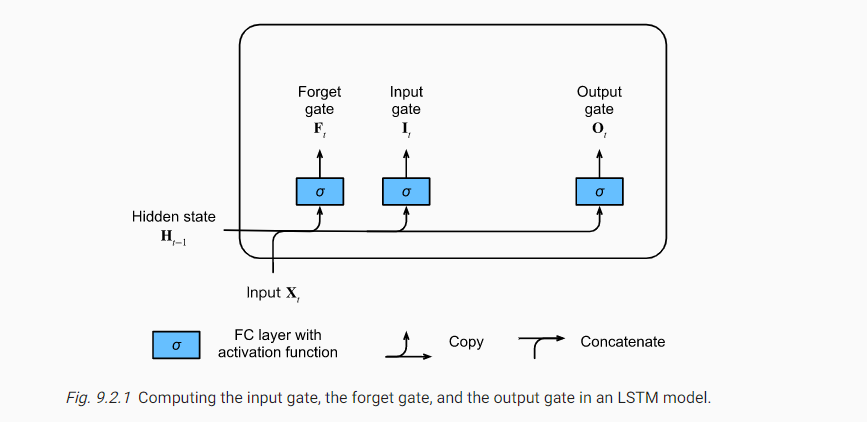
1. $I_t = \sigma (X_tW_{xi} + H_{t-1}W_{hi} + b_i)$
2. $F_t = \sigma (X_tW_{xf} + H_{t-1}W_{hf} + b_f)$
3. $O_t = \sigma (X_tW_{xo} + H_{t-1}W_{ho} + b_o)$

Where $W_{xi}, W_{xf}, W_{xo} \in R^{d*h}, W_{hi}, W_{hf}, W_{ho} \in R^{h*h}$


## Candiate Memory cell
Memory cell here can be considered as a special type of hidden state, the candidate memory cell here are shown below:
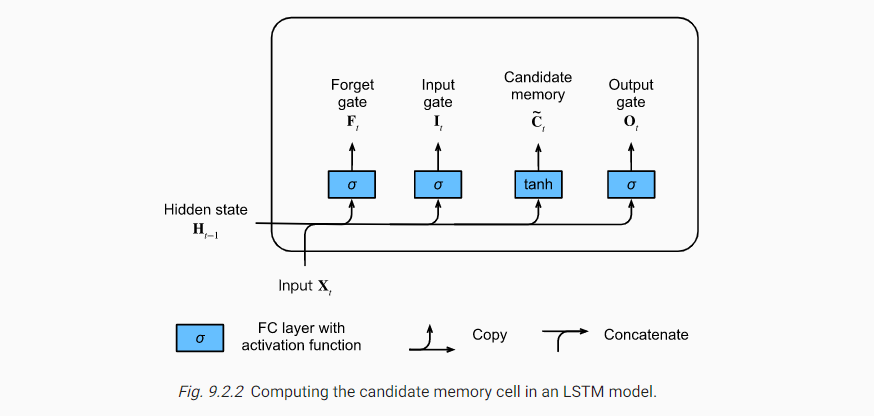

Where $C_t^c \in R^{n*h}$ by using tanh activation function. The formula is shown below:


Formula: $C_t^c = tanh (X_tW_{xc} + H_{t-1}W_{hc} + b_c)$, where we have two learnable weighted matrix $W_{xc} \in R^{d*h}, W_{hc} \in R^{h*h}$

## Memory cell
LSTMs have two dedicated gates for governing input and forgetting. the input gate $I_t$ governs how much we take new data into account via candidate memory cell C_t, the forget gate F_t address how much the old memory cell content C_{t-1} we retain here. The formula is shown below:

$C_t = F_t*C_{t-1} + I_t * C^c_t$

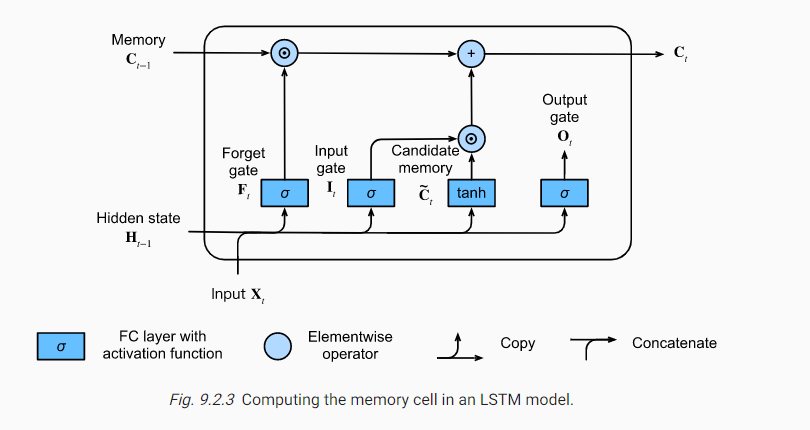

If the forget gate here is always approximately 1 and the input gate is always approximately 0, the past memory cells $C_{t-1}$ will be saved over time and passed to the current time step(which means when gate output is 0, in back propagation, the gradient will become 0 of sigmoid output, we not focus on it; else, gradient can be commonly passed result).

## Hidden state
Compute hidden state $H_t \in R^{n*h}$, in LSTM, it's simply a gated version of tanh of memory cell. Formula is shown below:

$H_t = O_t * tanh(C_t)$, which means the new hidden state is calculated based on time stampt $t^{th}$ memory cell and output gate result.

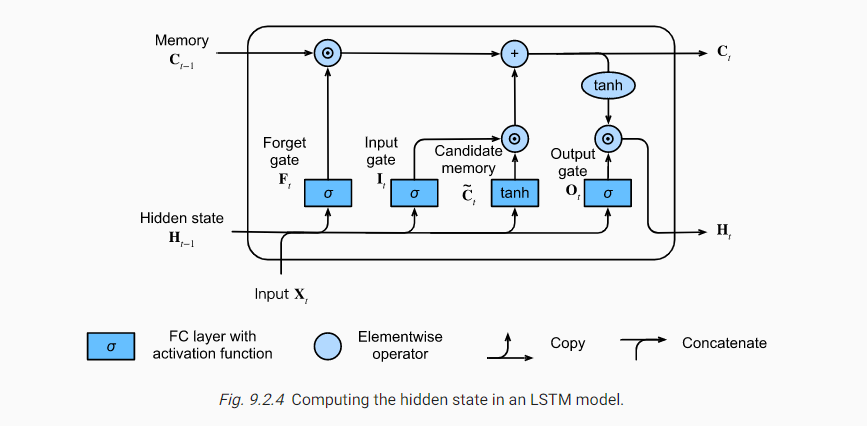

Similarly, when output gates sigmoid output approximately to 1, which means the next hidden state $H_t$ is almost the memory information; Else the next hidden state will retain all information only within the memory cell.

## Implementation

In [ ]:
import torch 
from torch import nn
import pandas as pd
import numpy as np
import math
from torch.cuda import amp
from transformers import get_cosine_schedule_with_warmup
from collections import Counter
import collections

In [ ]:
class LSTM_block(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, bias = True, decoder = False):
        '''
        Same as RNN and GRU, here I implement LSTM based on embedding matrix 
        instead sparse one-hot matrix
        '''
        super(LSTM_block, self).__init__()
        self.embedding_matrix = nn.Embedding(vocab_size, embed_size)
        self.num_hiddens = num_hiddens
        self.decoder = decoder
        if not decoder:
            self.W_xi = nn.Linear(embed_size, num_hiddens)
            self.W_xf = nn.Linear(embed_size, num_hiddens)
            self.W_xo = nn.Linear(embed_size, num_hiddens)
            self.W_xc = nn.Linear(embed_size, num_hiddens)
        else:
            self.W_xi = nn.Linear(embed_size + num_hiddens, num_hiddens)
            self.W_xf = nn.Linear(embed_size + num_hiddens, num_hiddens)
            self.W_xo = nn.Linear(embed_size + num_hiddens, num_hiddens)
            self.W_xc = nn.Linear(embed_size + num_hiddens, num_hiddens)
        # Params of input gates
        self.W_hi = nn.Linear(num_hiddens, num_hiddens, bias = bias)
        self.act_gate = nn.Sigmoid()
        # Params of forget gates
        
        self.W_hf = nn.Linear(num_hiddens, num_hiddens, bias = bias)
        # Params of output gates
        
        self.W_ho = nn.Linear(num_hiddens, num_hiddens,bias = bias)
        # Params of candidate memory cell
        
        self.W_hc = nn.Linear(num_hiddens, num_hiddens,bias = bias)
        self.act_state = nn.Tanh()
        # Params of final output 
        self.W_output = nn.Linear(num_hiddens, vocab_size, bias = bias)
    def init_state(self,bs, num_hiddens, device):
        return torch.zeros((bs, num_hiddens), device = device),torch.zeros((bs, num_hiddens), device = device)
    
    def forward(self, input_, hidden_state, memory_cell_state):
        # input_ size is (bs, max_len)
        if not self.decoder:
            input_ = self.embedding_matrix(input_)
        else:
            # if represent as decoder, concat the result
            context = hidden_state.repeat(input_.shape[1],1,1).permute(1,0,2)
            input_ = torch.cat((self.embedding_matrix(input_), context),2)
        outputs, state_ls, memory_ls = [],[],[]
        for i in input_.permute(1,0,2):
            # calculate input, output, forget gate 
            I = self.act_gate(self.W_xi(i) + self.W_hi(hidden_state))
            O = self.act_gate(self.W_xo(i) + self.W_ho(hidden_state))
            F = self.act_gate(self.W_xf(i) + self.W_hf(hidden_state))
            # calculate candidate state
            C = self.act_state(self.W_xc(i) + self.W_hc(hidden_state))
            memory_cell_state = F * memory_cell_state + I * C
            hidden_state = O * self.act_state(memory_cell_state)
            output = self.W_output(hidden_state)
            outputs.append(output.unsqueeze(1))
            state_ls.append(hidden_state)
            memory_ls.append(memory_cell_state)
        return torch.cat(outputs, dim = 1), state_ls[-1], memory_ls[-1]

In [ ]:
# test layer
x = torch.ones((2,6), dtype = torch.long)
lstm = LSTM_block(200, 100,24)
init = lstm.init_state(2, 24, torch.device("cpu"))
output_ls, hidden_ls, memory_ls = lstm(x, *init)

## Apply on machine translation task

In [ ]:
def clip_grad(net, theta):
    params = [p for p in net.parameters() if p.requires_grad and p.grad is not None]
    #[print(p.grad) for p in params]
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for para in params:
            para.grad[:] *= theta/norm
            
            
# basic processing code
class Build_vocabulary(object):
    '''
    Here we need to bulid a vocabulary for mapping
    '''
    def __init__(self, tokens = None, min_freq = 0, special_tokens = None):
        if tokens is None:
            tokens = []
        if special_tokens is None:
            special_tokens = []
        tokens = [token for line in tokens for token in line]
        counter = Counter(tokens)
        # sort by frequency
        self.freq = sorted(counter.items(), key = lambda x: x[1], reverse=True)
        # set special token
        self.idx_to_token = ["<unk>"] + special_tokens
        self.token_to_id = {token: ids for ids, token in enumerate(self.idx_to_token)}
        for token, freq in self.freq:
            if freq < min_freq:
                break
            if token not in self.token_to_id:
                self.idx_to_token.append(token)
                self.token_to_id[token] = len(self.idx_to_token) - 1
                
    #build some internal property
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, token):
        '''
        Return the token:ids for each input token in dict
        '''
        if not isinstance(token, (list, tuple)):
            return self.token_to_id.get(token, 0)
        return [self.__getitem__(token_) for token_ in token]
    
    def indices_to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

def read_dataset():
    with open("./fra-eng/fra.txt", "r", encoding="utf-8") as f:
        text = f.read()
        text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != " "
    out = []
    for i, char in enumerate(text):
        if i>0 and no_space(char, text[i-1]):
            out.append(' '+char)
        else:
            out.append(char)
    text = "".join(out)
    # Tokenization
    english_word, french_word = [], []
    for i, sentence in enumerate(text.split("\n")):
        # split by \t
        result = sentence.split("\t")
        if len(result) == 2:
            english_word.append(result[0].split(" "))
            french_word.append(result[1].split(" "))
    return english_word, french_word

def padding_truncation(tokens, max_lens, padding_token):
    if len(tokens) > max_lens:
        return tokens[:max_lens]
    return tokens + [padding_token]*(max_lens - len(tokens))

def build_array(tokens, dic, max_length):
    '''
    This function build the array of each token
    '''
    tokens_mapping = [dic[token] for token in tokens]
    tokens_mapping = [token + [dic["<eos>"]] for token in tokens_mapping]
    # add padding, truncation
    tensor = torch.tensor([padding_truncation(token, max_length, dic["<pad>"]) for token in tokens_mapping])
    valid_len = (tensor != dic["<pad>"]).type(torch.int32).sum(1)
    return tensor, valid_len

def processing_french_english_dataset(batch_size, max_length):
    english_word, french_word = read_dataset()
    english_mapping = Build_vocabulary(english_word, min_freq=2, 
                                   special_tokens=["<pad>", "<bos>", "<eos>"])
    french_mapping = Build_vocabulary(french_word, min_freq=2, 
                                   special_tokens=["<pad>", "<bos>", "<eos>"])
    english_array, english_valid_len = build_array(english_word, english_mapping, max_length)
    french_array, french_valid_len = build_array(french_word, french_mapping, max_length)
    dataset = torch.utils.data.TensorDataset(*(english_array, english_valid_len, french_array, french_valid_len))
    data_iter = torch.utils.data.DataLoader(dataset,batch_size = batch_size, shuffle = True)
    return data_iter, english_mapping, french_mapping

class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        #print(pred.shape, label.shape, valid_len.shape)
        weights = torch.ones_like(label)
        max_len = weights.size(1)
        mask = torch.arange((max_len), dtype = torch.float32,
                           device = weights.device)[None,:] < valid_len[:,None]
        weights[~mask] = 0
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [ ]:
class LSTM_decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, bias = True):
        super(LSTM_decoder,self).__init__()
        self.rnn = LSTM_block(vocab_size, embed_size, num_hiddens, bias=bias,decoder=True)
    
    def init_state(self, encoder_hidden, encoder_mc):
        return (encoder_hidden, encoder_mc)
    
    def forward(self, input_, hidden_state, cell_state):
        #print(hidden_state.shape), print(cell_state.shape)
        output_ls, final_hidden_state,_ = self.rnn(input_, hidden_state,cell_state)
        return output_ls, final_hidden_state

In [ ]:
class LSTM_seq2seq(nn.Module):
    def __init__(self, encoder, decoder, **kwargs):
        super(LSTM_seq2seq, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, encoder_input, decoder_input, device):
        init_state = self.encoder.init_state(encoder_input.shape[0],self.encoder.num_hiddens,device)
        encoder_output, encoder_hidden, encoder_memory_cell = self.encoder(encoder_input, *init_state)
        decoder_state = self.decoder.init_state(encoder_hidden, encoder_memory_cell)
        return self.decoder(decoder_input, *decoder_state)

In [ ]:
# set parameters, here i just use 1-layer (instead stacked layer to test the result)
num_hiddens,bs, num_step= 64,128,10
lr, num_epochs, device = 2e-4, 200, torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
train_iter, english_mapping, french_mapping =processing_french_english_dataset(bs,num_step)
rnn_encoder = LSTM_block(len(english_mapping), num_hiddens, num_hiddens)
rnn_decoder = LSTM_decoder(len(french_mapping), num_hiddens, num_hiddens)
RNN_s2s = LSTM_seq2seq(rnn_encoder, rnn_decoder)
criterion = MaskedSoftmaxCELoss()
optimizer = torch.optim.Adam(RNN_s2s.parameters(), lr = lr)
scheduler = get_cosine_schedule_with_warmup(optimizer= optimizer, num_warmup_steps = 0, 
                                                num_training_steps= len(train_iter), num_cycles = 0.5)
num_gpu = 1
max_grad_norm = 1000

In [ ]:
def train(net, train_iter,criterion, optimizer, epochs, scheduler, gradient_accumulate_step, max_grad_norm ,num_gpu,
        target_vocab):
    net.train()   
    # instantiate a scalar object 
    ls          = []
    #device_ids  = [try_gpu(i) for i in range(num_gpu)]
    device  = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    print("\ntrain on %s\n"%str(device))
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
    net.apply(xavier_init_weights)
    net.to(device)
    for epoch in range(epochs):
        net.train()
        for idx, value in enumerate(train_iter):
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in value]
            # when forward process, use amp
            bos = torch.tensor([target_vocab["<bos>"]]*Y.shape[0], device = device).reshape(-1,1)
            # this called teacher forcing
            decoder_input = torch.cat([bos, Y[:,:-1]], 1)
            output,_ = net(X, decoder_input,device)
            # calculate masked loss
            loss        = criterion(output, Y, Y_valid_len)
            # prevent gradient to 0
            if gradient_accumulate_step > 1:
                # 如果显存不足，通过 gradient_accumulate 来解决
                loss    = loss/gradient_accumulate_step
            #print(loss.shape)
            loss.sum().backward()
            # do the gradient clip
            gradient_norm = nn.utils.clip_grad_norm_(net.parameters(),max_grad_norm)
            #if idx > 0:
            clip_grad(net, 1)
            if (idx + 1) % gradient_accumulate_step == 0:
                # 多少 step 更新一次梯度
                optimizer.step()
                scheduler.step()
                #print("done 1 train")
            # 每1000次计算 print 出一次loss
            if idx % 30 == 0 or idx == len(train_iter) -1:
                with torch.no_grad():
                    print("==============Epochs "+ str(epoch) + " ======================")
                    print("loss: " + str(loss.mean()) + "; grad_norm: " + str(gradient_norm))
                    ls.append(loss.mean().item())
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': net.state_dict(),
                    'loss': ls
                },"./checkpoint.params")

In [ ]:
train(RNN_s2s, train_iter, criterion,optimizer, num_epochs, scheduler,1,max_grad_norm,
     num_gpu,french_mapping)